# Setup

In [26]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def get_kernelized_ls_ds(N=25, s=.2, lim=(-5, 5)):
    np.random.seed(98)
    f = lambda x: np.sin(0.9*x).flatten()
    X = np.random.uniform(lim[0], lim[1], size=N)
    y = f(X) + s*np.random.randn(N)
    return (X,y,f)

def get_dna_sequences():
    X_train = ["TCCGTTACCGTGTAACCGACGCCAAGACCGAG", "GCTTGTAATCTGTTTTGACGCCCTCGTCCATGATG", "AGTCAAGCTTTGGTTATTTGTGGTGTTCAATA",\
         "ACCTGAATCTAGTAACCGACGGCGTGTACGATA", "CTTAAAACCTGTTATTAATGCGGTAAAAT", "CCTGCATGCGTGGAAGTGACGCCTATCCAT",\
         "TGTTATACCTTTGGATCATTATTGAGTGAAA", "CTTCAACGCCTATTATTTTGGGTGTGAAAT", "ACCGTAAGTGTTACAGACCGTAAGTACCGTTG",\
         "CGTTCAACGCCTAGGTGTATTGGGTGTCTG"]
    y_train = [1, 1, -1, 1, -1, 1, -1, -1, 1, -1]

    X_test = ["CTTTCAAGGCCCTAATTATCATTGGGTTGAAT", "CGTACCACCCTTCGTTGATGTTTCCGGGAAT", "TCGTACTGCGAACTGAGCCTAGTGACCGACG"]
    y_test = [-1, 1, 1]

    return (X_train, y_train, X_test, y_test)

# Kernel Methods

## Kernelized Least Squares
In this task, we will implement a least squares which utilizes kernels. We will use the *dual representation* to make predictions.
Use the following data:

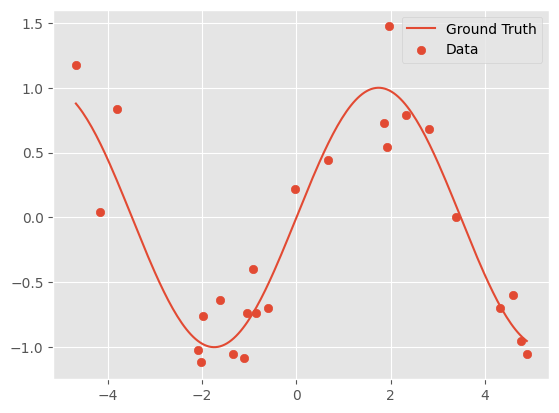

In [27]:
X, y, f = get_kernelized_ls_ds()

axis = np.linspace(min(X), max(X), 201)
plt.plot(axis, f(axis), label='Ground Truth')
plt.scatter(X, y, label='Data')
plt.legend()
plt.show()

> Implement the Gaussian kernel (also called radial basis function kernel):
> $$k\left(\mathbf{x}, \mathbf{x}^{\prime}\right)=\exp \left(-\left\|\mathbf{x}-\mathbf{x}^{\prime}\right\|^{2} / 2 \sigma^{2}\right)$$

In [28]:
class GaussianKernel:
    def __init__(self, h):
        self.width = h

    def __call__(self, u, v):
        u = np.array(u)
        v = np.array(v)
        return np.exp(-np.linalg.norm(u-v)**2 / (2*self.width**2))

kernel = GaussianKernel(h=1)
kernel([1, 2], [2, 1]) # returns 0.36787944117144233

0.3678794411714422

> Implement the following methods for the class `KernelizedRegression`:
> - `init`: Init the Regression model and set the kernel function.
> - `fit`: Calculate the gram martix $\mathbf{K}$ and $\mathbf{a}$ according to $$K_{n m}=k\left(\mathbf{x}_{n}, \mathbf{x}_{m}\right) \quad \quad \mathbf{a}=\left(\mathbf{K}+\lambda \mathbf{I}_{N}\right)^{-1} \mathbf{t}$$
> - `predict`: Exploit $\mathbf{a}$ to make predictions according to $$y(\mathbf{x}) = \mathbf{k}(\mathbf{x})^{\mathrm{T}} \underbrace{\left(\mathbf{K}+\lambda \mathbf{I}_{N}\right)^{-1} \mathbf{t}}_{\mathbf{a}}$$

In [29]:
class KernelizedRegression:
    def __init__(self, kernel_func):
        self.kernelfunc = kernel_func
        

    def fit(self, X, y, lmb=0):
        self.X = X
        self.K = np.array([[self.kernelfunc(x1, x2) for x1 in X] for x2 in X])
        self.a = np.linalg.inv(self.K + lmb*np.eye(len(X))) @ y

    def predict(self, x):
        k = np.array([self.kernelfunc(x, xi) for xi in self.X])
        return k.T @ self.a

clf = KernelizedRegression(GaussianKernel(h=1))
clf.fit(X, y)
clf.predict(0.5)

-132.7110024819926

>Use the implemented model to make predictions for our regression task defined above. Try different values for $\lambda$.

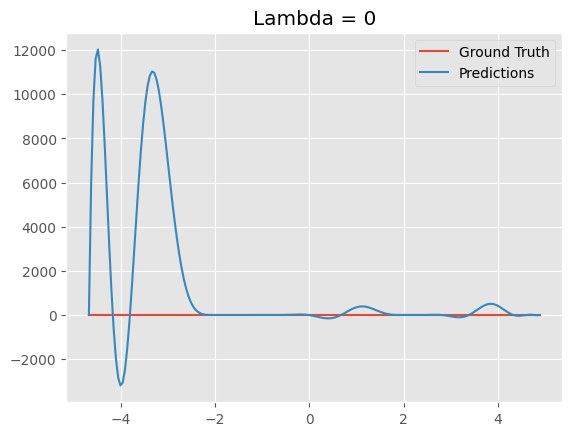

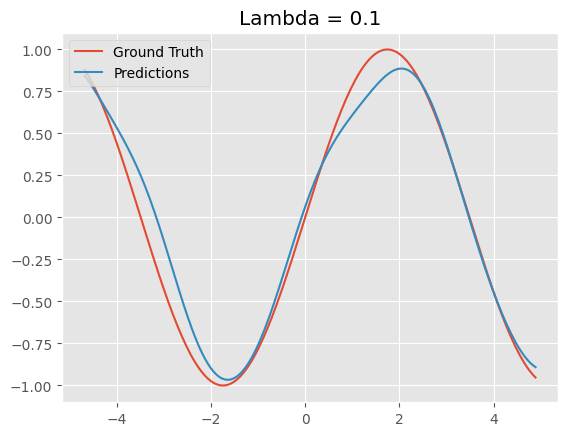

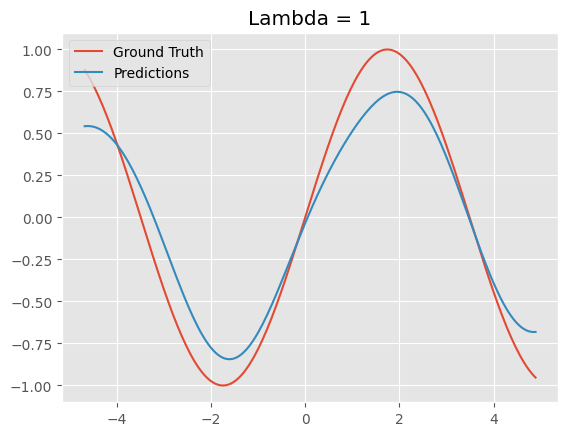

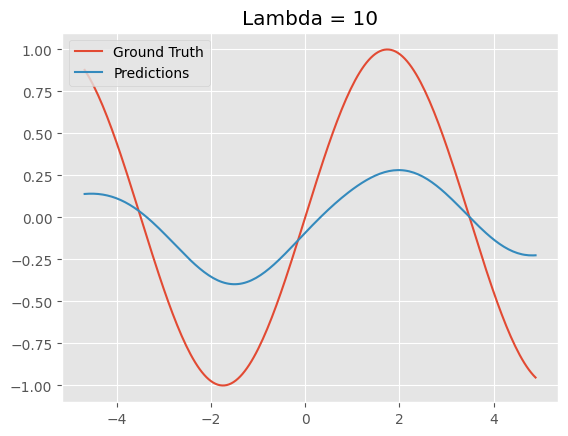

In [30]:
X, y, f = get_kernelized_ls_ds()

for l in [0, 0.1, 1, 10]:# lambda is used as weight decay (if lamda bigger, the model is more simple-> linear model)
    clf = KernelizedRegression(GaussianKernel(h=1))
    clf.fit(X, y, l)
    axis = np.linspace(min(X), max(X), 201)
    plt.title("Lambda = " + str(l))
    plt.plot(axis, f(axis), label='Ground Truth')
    plt.plot(axis, [clf.predict(x) for x in axis], label='Predictions')
    plt.legend()
    plt.show()

> Find the best parameters for $\lambda$ and the bandwidth parameter of the gaussian kernel by using grid search and cross validation. For that, use  `KFold` from `sklearn.model_selection` and plot the *best* model.

In [31]:
from sklearn.model_selection import KFold, GridSearchCV

kf = KFold(n_splits=3, shuffle=True, random_state=42)
parameters = {'lambda':[0,10], 'width':[1, 10]}

mse_scores = {}
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    for l in [0, 0.1, 1, 10]:
        for h in [0.1, 1, 10]:
            clf = KernelizedRegression(GaussianKernel(h=h))
            clf.fit(X_train, y_train, l)
            mse_scores[(l, h)] = mse_scores.get((l, h), 0) + np.mean((clf.predict(X_test) - y_test)**2)
            #print("Lambda: ", l, "Bandwidth: ", h, "MSE: ", np.mean((clf.predict(X_test) - y_test)**2))
print("MSE Scores: ", mse_scores)          
best_params = min(mse_scores, key=mse_scores.get)
print("Best Parameters: ", best_params)

MSE Scores:  {(0, 0.1): 2.008391989627098, (0, 1): 2.0083919677988167, (0, 10): 1.3598338884539366e+22, (0.1, 0.1): 2.008391989627098, (0.1, 1): 2.0083919896271962, (0.1, 10): 14.097575539839225, (1, 0.1): 2.008391989627098, (1, 1): 2.008391989627122, (1, 10): 2.5256646112802423, (10, 0.1): 2.008391989627098, (10, 1): 2.0083919896271, (10, 10): 2.0677532836845485}
Best Parameters:  (0, 1)


##  Diferent Kernels

### Example DNA

Consider the following training data which resembles DNA sequences and coressponding labels.
The sequences are $x \in \{A, C, G, T \}*$ while the labels are either $1$ or $-1$.

In [32]:
X_train, y_train, X_test, y_test = get_dna_sequences()
X_train, y_train

(['TCCGTTACCGTGTAACCGACGCCAAGACCGAG',
  'GCTTGTAATCTGTTTTGACGCCCTCGTCCATGATG',
  'AGTCAAGCTTTGGTTATTTGTGGTGTTCAATA',
  'ACCTGAATCTAGTAACCGACGGCGTGTACGATA',
  'CTTAAAACCTGTTATTAATGCGGTAAAAT',
  'CCTGCATGCGTGGAAGTGACGCCTATCCAT',
  'TGTTATACCTTTGGATCATTATTGAGTGAAA',
  'CTTCAACGCCTATTATTTTGGGTGTGAAAT',
  'ACCGTAAGTGTTACAGACCGTAAGTACCGTTG',
  'CGTTCAACGCCTAGGTGTATTGGGTGTCTG'],
 [1, 1, -1, 1, -1, 1, -1, -1, 1, -1])

> Implement a kernel function `dna_kernel(u, v)` that is defined as the number of different sub sequences of length 3 between both samples `u` and `v` (i.e., the number of 3 character substrings which are unique in each sequence).
___

#### Example: `ABCDEF` and `CDEFGH`
1. Check if `ABC` in `CDEFGH` -- `ABC` is not in `CDEFGH`
2. Check if `BCD` in `CDEFGH` -- `BCD` is not in `CDEFGH`
3. Check if `CDE` in `CDEFGH` -- `CDE` is in `CDEFGH`
4. Check if `DEF` in `CDEFGH` -- `DEF` is in `CDEFGH`

Since the substrings `CDE` and `DEF` appear in `CDEFGH`: `dna_kernel(ABCDEF, CDEFGH) = 2`.
___

In [33]:
def dna_kernel(u, v):
    count = 0
    for i in range(len(u)-2):
        if u[i:i+3] in v:
            count += 1
    return count
dna_kernel("ABCDEF", "CDEFGH") # returns 2

2

> Fit the kernelized regression model using this new kernel function. Use `plt.matshow` to visualize the gram matrix $\mathbf{K}$. How can you interpret the resulting plot?

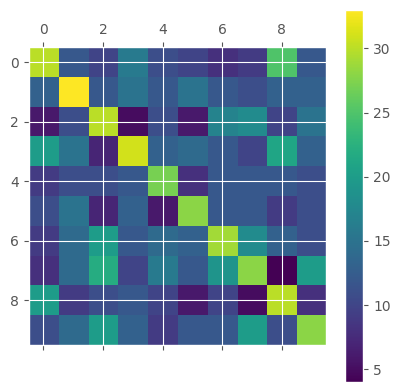

In [34]:
clf = KernelizedRegression(dna_kernel)
clf.fit(X_train, y_train)
plt.matshow(clf.K)
plt.colorbar()
plt.show()

> In order to make predictions in this classification task, we need to alter the predicted output. For that, use the `np.sign` function and evalutae your model using the `log_loss` from `sklearn.metrics`.

In [35]:
from sklearn.metrics import log_loss    
clf = KernelizedRegression(dna_kernel)
clf.fit(X_train, y_train)
y_pred = np.sign(np.array([np.sign(clf.predict(x)) for x in X_test]))
print(log_loss(y_test, y_pred))

2.2204460492503136e-16
